# 1. Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import lime
import lime.lime_tabular
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, roc_auc_score, f1_score, make_scorer)
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

# 2. Load the Dataset

In [2]:
kepler_path = "../Data/Kepler.csv"
kepler = pd.read_csv(kepler_path, comment='#', delimiter=',')

print(f"number of rows: {kepler.shape[0]}")
print(f"number of columns: {kepler.shape[1]}")

number of rows: 9564
number of columns: 141


# 3. Initial Data Overview

In [3]:
print("\n📌 First 5 rows of the dataset:")
display(kepler.head())


📌 First 5 rows of the dataset:


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [4]:
print("\n📌 Dataset Info:")
kepler.info()


📌 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Columns: 141 entries, rowid to koi_dikco_msky_err
dtypes: float64(117), int64(7), object(17)
memory usage: 10.3+ MB


In [5]:
print("\n📌 Description of Numeric Columns:")
display(kepler.describe())


📌 Description of Numeric Columns:


,rowid,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
count,9564.000000,9.564000e+03,8054.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9110.000000,9110.000000,...,8965.000000,8965.000000,8965.000000,8965.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000
mean,4782.500000,7.690628e+06,0.480829,0.208595,0.232748,0.197512,0.120033,75.671358,0.002148,-0.002148,...,-0.045420,0.446229,1.866561,0.489930,-0.024244,0.425337,-0.076749,0.436684,1.812566,0.476060
std,2761.033321,2.653459e+06,0.476928,4.767290,0.422605,0.398142,0.325018,1334.744046,0.008236,0.008236,...,2.573558,0.569933,2.988742,0.646403,2.382286,0.602150,2.553758,0.567535,2.986376,0.647587
min,1.000000,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,0.000000,-0.172500,...,-75.900000,0.067000,0.000000,0.067000,-27.800000,0.067000,-76.600000,0.067000,0.000000,0.067000
25%,2391.750000,5.556034e+06,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,0.000005,-0.000276,...,-0.387000,0.098000,0.170000,0.100000,-0.310000,0.087000,-0.390000,0.090000,0.210000,0.094000
50%,4782.500000,7.906892e+06,0.334000,0.000000,0.000000,0.000000,0.000000,9.752831,0.000035,-0.000035,...,0.000000,0.280000,0.610000,0.310000,-0.004000,0.250000,-0.017000,0.270000,0.583000,0.290000
75%,7173.250000,9.873066e+06,0.998000,0.000000,0.000000,0.000000,0.000000,40.715178,0.000276,-0.000005,...,0.300000,0.610000,2.160000,0.680000,0.290000,0.590000,0.300000,0.600000,1.970000,0.660000
max,9564.000000,1.293514e+07,1.000000,465.000000,1.000000,1.000000,1.000000,129995.778400,0.172500,0.000000,...,27.500000,22.000000,88.600000,32.000000,46.570000,33.000000,34.000000,22.000000,89.600000,32.000000


# 4. Check for Missing Values

In [6]:
print("\n📌 Missing Values:")
display(kepler.isnull().sum())


📌 Missing Values:


rowid                    0
kepid                    0
kepoi_name               0
kepler_name           6817
koi_disposition          0
                      ... 
koi_dikco_mra_err      570
koi_dikco_mdec         570
koi_dikco_mdec_err     570
koi_dikco_msky         570
koi_dikco_msky_err     570
Length: 141, dtype: int64

In [7]:
kepler_clean = kepler.dropna(axis=1, thresh=len(kepler)*0.5)

# 5. Importent Feature

In [8]:
important_columns = [
    'koi_period', 'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq',
    'koi_insol', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_dor',
    'koi_ror',
    
    'koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass', 'koi_srho',
    
    'koi_num_transits', 'koi_count', 'koi_model_snr',
    
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
    
    'koi_disposition'
]

In [9]:
available_cols = [col for col in important_columns if col in kepler_clean.columns]

kepler_clean = kepler_clean[available_cols].copy()

print(f"\nNumber of selected columns: {len(available_cols)-1}")


Number of selected columns: 24


# 6. Process target variable (3 classes)

In [10]:
kepler_clean['koi_disposition'].value_counts()

koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64

In [11]:
disposition_mapping = {
    'FALSE POSITIVE': 0,
    'CANDIDATE': 1,
    'CONFIRMED': 2
}

In [12]:
# Encode target variable and remove the original column
kepler_clean['target'] = kepler_clean['koi_disposition'].map(disposition_mapping)
kepler_clean = kepler_clean.drop('koi_disposition', axis=1)

In [13]:
# Class distribution after encoding
class_names = ['FALSE POSITIVE', 'CANDIDATE', 'CONFIRMED']
print("\nClass distribution after encoding:")
class_dist = kepler_clean['target'].value_counts().sort_index()
for i, count in class_dist.items():
    print(f"  {class_names[i]} ({i}): {count} ({count/len(kepler_clean)*100:.1f}%)")


Class distribution after encoding:
  FALSE POSITIVE (0): 4839 (50.6%)
  CANDIDATE (1): 1979 (20.7%)
  CONFIRMED (2): 2746 (28.7%)


# 7. Feature Engineering

In [14]:
def create_features(df):
    """create new features"""
    df = df.copy()
    
    if 'koi_prad' in df.columns and 'koi_srad' in df.columns:
        df['planet_star_radius_ratio'] = df['koi_prad'] / (df['koi_srad'] + 1e-10)
    
    if 'koi_period' in df.columns and 'koi_duration' in df.columns:
        df['period_duration_ratio'] = df['koi_period'] / (df['koi_duration'] + 1e-10)
    
    if 'koi_smass' in df.columns and 'koi_srad' in df.columns:
        df['star_density_proxy'] = df['koi_smass'] / (df['koi_srad']**3 + 1e-10)
    
    if 'koi_insol' in df.columns and 'koi_teq' in df.columns:
        df['insol_teq_ratio'] = df['koi_insol'] / (df['koi_teq'] + 1e-10)
    
    if 'koi_depth' in df.columns and 'koi_duration' in df.columns:
        df['signal_strength'] = df['koi_depth'] * df['koi_duration']
    
    fp_flags = ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']
    available_fp_flags = [col for col in fp_flags if col in df.columns]
    if available_fp_flags:
        df['total_fp_flags'] = df[available_fp_flags].sum(axis=1)
    
    return df


In [15]:
kepler_clean = create_features(kepler_clean)
print(f"Number of features after engineering: {kepler_clean.shape[1]-1}")

Number of features after engineering: 30


# 8. Train/ Validation/ Test Split

In [16]:
X = kepler_clean.drop('target', axis=1)
y = kepler_clean['target']

In [17]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

In [19]:
print(f"Train size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation size: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

Train size: 6120 (64.0%)
Validation size: 1531 (16.0%)
Test size: 1913 (20.0%)


# 9. Missing values handling and normalization

In [20]:
# Imputer
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)

X_train_imputed = pd.DataFrame(
    imputer.transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_imputed = pd.DataFrame(
    imputer.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

In [21]:
# Scaler
scaler = StandardScaler()
scaler.fit(X_train_imputed)

X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_imputed),
    columns=X_val_imputed.columns,
    index=X_val_imputed.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

# 10. Calculate Class Weights

In [22]:
classes = np.unique(y_train)  
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)  
class_weights = dict(zip(classes, weights))  

print(f"\nClass Weights:")  
for cls, weight in class_weights.items():  
    print(f"  {class_names[cls]}: {weight:.3f}")  


Class Weights:
  FALSE POSITIVE: 0.659
  CANDIDATE: 1.611
  CONFIRMED: 1.161


# 11. Train model

In [23]:
model = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    metric='multi_logloss',
    learning_rate=0.03,
    num_leaves=31,
    max_depth=6,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    class_weight=class_weights,
    n_estimators=500,
    random_state=42,
    verbose=-1
)

model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)], 
    eval_metric='multi_logloss',
    callbacks=[
        lgb.early_stopping(50, verbose=False),
        lgb.log_evaluation(50)
    ]
)

[50]	valid_0's multi_logloss: 0.294142
[100]	valid_0's multi_logloss: 0.1946
[150]	valid_0's multi_logloss: 0.177158
[200]	valid_0's multi_logloss: 0.173205
[250]	valid_0's multi_logloss: 0.172348
[300]	valid_0's multi_logloss: 0.173635


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.03
,n_estimators,500
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,"{np.int64(0): np.float64(0.6587019696480465), np.int64(1): np.float64(1.6113744075829384), np.int64(2): np.float64(1.1610700056915197)}"
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


# 12. Evaluation

<Figure size 1200x600 with 0 Axes>

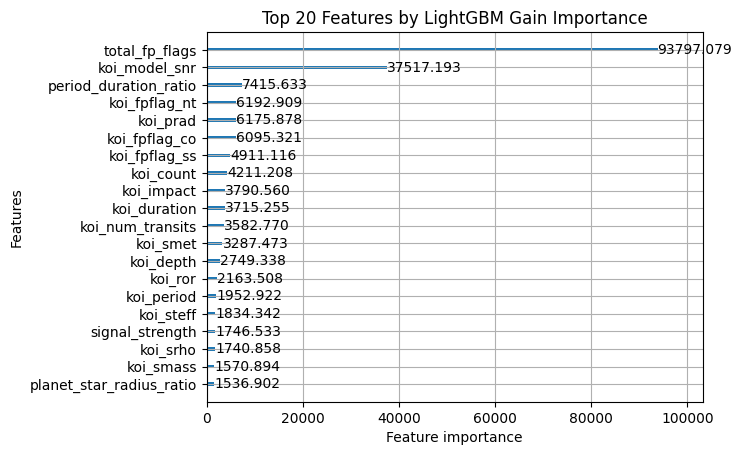

In [24]:
plt.figure(figsize=(12, 6))
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Features by LightGBM Gain Importance")
plt.show()

In [25]:
y_val_pred = model.predict(X_val_scaled)
y_val_pred_proba = model.predict_proba(X_val_scaled)

val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation F1-Score: {val_f1:.4f}")

Validation Accuracy: 92.88%
Validation F1-Score: 0.9291


In [26]:
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"\n📊 Test Accuracy: {acc*100:.2f}%")


📊 Test Accuracy: 93.52%


In [27]:
# F1-Score
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"📊 Test F1-Score (weighted): {f1_weighted:.4f}")
print(f"📊 Test F1-Score (macro): {f1_macro:.4f}")

📊 Test F1-Score (weighted): 0.9354
📊 Test F1-Score (macro): 0.9131


In [28]:
# ROC-AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f"📊 Test ROC-AUC (weighted): {roc_auc:.4f}")

📊 Test ROC-AUC (weighted): 0.9901


In [29]:
# Classification Report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred, 
                          target_names=class_names,
                          digits=4))


Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE     0.9938    0.9907    0.9922       968
     CANDIDATE     0.8382    0.8636    0.8507       396
     CONFIRMED     0.9037    0.8889    0.8962       549

      accuracy                         0.9352      1913
     macro avg     0.9119    0.9144    0.9131      1913
  weighted avg     0.9357    0.9352    0.9354      1913




✅ done save : confusion_matrix_multiclass.png


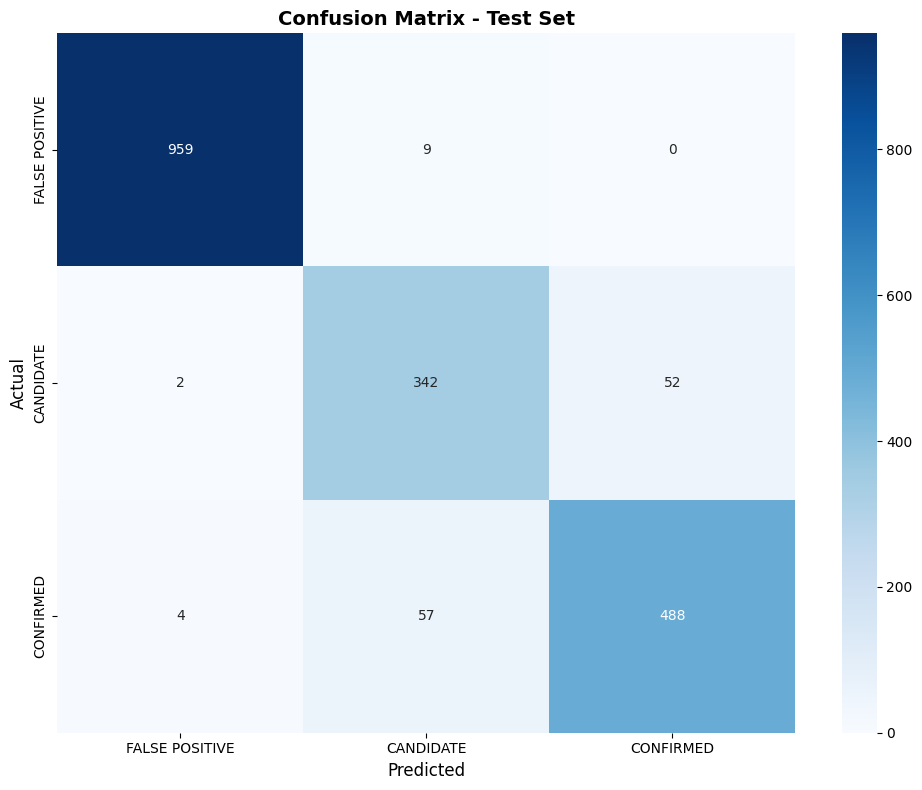

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_multiclass.png', dpi=300, bbox_inches='tight')
print("\n✅ done save : confusion_matrix_multiclass.png")

In [31]:
# Error Analysis
print("\n" + "="*60)
print("Error Analysis:")
print("="*60)
for i, class_name in enumerate(class_names):
    correct = cm[i, i]
    total = cm[i].sum()
    errors = total - correct
    print(f"{class_name}:")
    print(f"  ✅ Correct: {correct}/{total} ({correct/total*100:.1f}%)")
    print(f"  ❌ Errors: {errors}/{total} ({errors/total*100:.1f}%)")
    if errors > 0:
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                print(f"     → Misclassified {cm[i, j]} as {class_names[j]}")



Error Analysis:
FALSE POSITIVE:
  ✅ Correct: 959/968 (99.1%)
  ❌ Errors: 9/968 (0.9%)
     → Misclassified 9 as CANDIDATE
CANDIDATE:
  ✅ Correct: 342/396 (86.4%)
  ❌ Errors: 54/396 (13.6%)
     → Misclassified 2 as FALSE POSITIVE
     → Misclassified 52 as CONFIRMED
CONFIRMED:
  ✅ Correct: 488/549 (88.9%)
  ❌ Errors: 61/549 (11.1%)
     → Misclassified 4 as FALSE POSITIVE
     → Misclassified 57 as CANDIDATE


# 13. Cross-Validation

In [32]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(
        objective='multiclass',
        num_class=3,
        metric='multi_logloss',
        learning_rate=0.03,
        num_leaves=31,
        max_depth=6,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        class_weight=class_weights,
        n_estimators=200,  
        random_state=42,
        verbose=-1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"CV Scores per fold: {cv_scores}")

cv_f1_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_weighted', n_jobs=-1)
print(f"CV F1-Score (weighted): {cv_f1_scores.mean():.4f} (+/- {cv_f1_scores.std():.4f})")

CV Accuracy: 0.9292 (+/- 0.0045)
CV Scores per fold: [0.93047569 0.92577104 0.93518035 0.93204391 0.92259414]
CV F1-Score (weighted): 0.9296 (+/- 0.0045)


In [33]:
joblib.dump(model, 'exoplanet_model_multiclass.pkl')
joblib.dump(imputer, 'imputer.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# 14. Example

In [34]:
for i in range(3):
    mask = y_test == i
    if mask.sum() > 0:
        # ✅ Take the first sample from this class
        idx = y_test[mask].index[0]
        sample = X_test_scaled.loc[idx:idx]  
        actual = y_test.loc[idx]  
        
        prediction = model.predict(sample)[0]
        probabilities = model.predict_proba(sample)[0]
        
        print(f"\nSample from {class_names[i]}:")
        print(f"  Actual: {class_names[actual]}")
        print(f"  Prediction: {class_names[prediction]}")
        print(f"  Probabilities:")
        for j, prob in enumerate(probabilities):
            print(f"    {class_names[j]}: {prob*100:.2f}%")
        print(f"  Result: {'✅ Correct' if prediction == actual else '❌ Wrong'}")



Sample from FALSE POSITIVE:
  Actual: FALSE POSITIVE
  Prediction: FALSE POSITIVE
  Probabilities:
    FALSE POSITIVE: 99.94%
    CANDIDATE: 0.03%
    CONFIRMED: 0.03%
  Result: ✅ Correct

Sample from CANDIDATE:
  Actual: CANDIDATE
  Prediction: CANDIDATE
  Probabilities:
    FALSE POSITIVE: 0.12%
    CANDIDATE: 95.63%
    CONFIRMED: 4.25%
  Result: ✅ Correct

Sample from CONFIRMED:
  Actual: CONFIRMED
  Prediction: CONFIRMED
  Probabilities:
    FALSE POSITIVE: 0.02%
    CANDIDATE: 0.52%
    CONFIRMED: 99.46%
  Result: ✅ Correct


In [35]:
sample_data = {
    "koi_period": 41.74938613,
    "koi_prad": 2.94,
    "koi_sma": 0.228,
    "koi_incl": 89.77,
    "koi_teq": 486.0,
    "koi_insol": 13.22,
    "koi_impact": 0.226,
    "koi_duration": 5.6098,
    "koi_depth": 1055.4,
    "koi_dor": 57.11,
    "koi_eccen": 0.0,
    "koi_ror": 0.029414,
    "koi_steff": 5506.0,
    "koi_slogg": 4.473,
    "koi_smet": 0.04,
    "koi_srad": 0.914,
    "koi_smass": 0.904,
    "koi_srho": 2.02141,
    "koi_num_transits": 34.0,
    "koi_count": 3,
    "koi_model_snr": 95.0,
    "koi_fpflag_nt": 0,
    "koi_fpflag_ss": 0,
    "koi_fpflag_co": 0,
    "koi_fpflag_ec": 0,
    "planet_star_radius_ratio": 3.2166301965846134,
    "period_duration_ratio": 7.442223631725868,
    "star_density_proxy": 1.1839404077027744,
    "insol_teq_ratio": 0.027201646090529386,
    "signal_strength": 5920.582920000001,
    "total_fp_flags": 0
}


sample_df = pd.DataFrame([sample_data])

sample_df = sample_df[X_train.columns]

sample_scaled = scaler.transform(sample_df)

prediction = model.predict(sample_scaled)[0]
probabilities = model.predict_proba(sample_scaled)[0]

print("Prediction:", class_names[prediction])
print("Probabilities:")
for j, prob in enumerate(probabilities):
    print(f"  {class_names[j]}: {prob*100:.2f}%")


Prediction: CONFIRMED
Probabilities:
  FALSE POSITIVE: 0.02%
  CANDIDATE: 0.52%
  CONFIRMED: 99.46%


# Round 2

# Ensemble Voting

LightGBM Validation Accuracy: 0.9295
XGBoost Validation Accuracy: 0.9275
RandomForest Validation Accuracy: 0.9314

Ensemble Validation Accuracy: 0.9314

Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       774
           1       0.84      0.83      0.84       317
           2       0.89      0.91      0.90       440

    accuracy                           0.93      1531
   macro avg       0.91      0.91      0.91      1531
weighted avg       0.93      0.93      0.93      1531



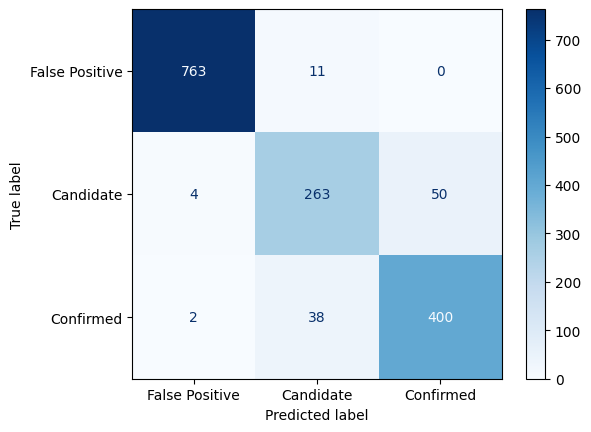

In [36]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import numpy as np

# -----------------------------
# 1️⃣ Instantiate Models
# -----------------------------
lgb_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(y_train.unique()),
    learning_rate=0.05,
    n_estimators=500,
    num_leaves=31,
    class_weight='balanced',
    random_state=42
)

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(y_train.unique()),
    learning_rate=0.05,
    n_estimators=300,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='mlogloss',
    seed=42
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

# -----------------------------
# 2️⃣ Train Models Individually
# -----------------------------
lgb_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train_scaled, y_train)

# -----------------------------
# 3️⃣ Calculate Accuracy Individually
# -----------------------------
models = {'LightGBM': lgb_model, 'XGBoost': xgb_model, 'RandomForest': rf_model}

for name, model in models.items():
    y_pred = model.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} Validation Accuracy: {acc:.4f}")

# -----------------------------
# 4️⃣ Ensemble Voting
# -----------------------------
ensemble = VotingClassifier(
    estimators=[('lgb', lgb_model), ('xgb', xgb_model), ('rf', rf_model)],
    voting='soft'
)

ensemble.fit(X_train_scaled, y_train)  # ممكن فعليًا يكون اتدرب قبل، لكن للتأكد
y_val_pred_ensemble = ensemble.predict(X_val_scaled)

acc_ensemble = accuracy_score(y_val, y_val_pred_ensemble)
print(f"\nEnsemble Validation Accuracy: {acc_ensemble:.4f}\n")

# Classification Report
print("Ensemble Classification Report:\n", classification_report(y_val, y_val_pred_ensemble))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_ensemble)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False Positive', 'Candidate', 'Confirmed'])
disp.plot(cmap='Blues', values_format='d')


# Round 3

# Class Imbalance Handling

In [37]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import classification_report

classes, counts = np.unique(y_train, return_counts=True)
print(dict(zip(classes, counts)))

class_weights = {0: 1.0, 1: 2.0, 2: 1.5}

lgb_clf = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(y_train.unique()),
    metric="multi_logloss",
    learning_rate=0.05,
    num_leaves=31,
    class_weight=class_weights,
    n_estimators=500,
    random_state=42
)

lgb_clf.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    callbacks=[
        lgb.early_stopping(20),
        lgb.log_evaluation(50)
    ]
)

# Predict
y_val_pred_weighted = lgb_clf.predict(X_val_scaled)

# Report
print(classification_report(y_val, y_val_pred_weighted))


{np.int64(0): np.int64(3097), np.int64(1): np.int64(1266), np.int64(2): np.int64(1757)}
Training until validation scores don't improve for 20 rounds
[50]	valid_0's multi_logloss: 0.201469
[100]	valid_0's multi_logloss: 0.171909
Early stopping, best iteration is:
[105]	valid_0's multi_logloss: 0.171631
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       774
           1       0.83      0.85      0.84       317
           2       0.90      0.90      0.90       440

    accuracy                           0.93      1531
   macro avg       0.91      0.91      0.91      1531
weighted avg       0.93      0.93      0.93      1531



Train class distribution: {np.int64(0): np.int64(3387), np.int64(1): np.int64(1385), np.int64(2): np.int64(1922)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 63, 'min_child_samples': 40, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.609942
[100]	valid_0's multi_logloss: 0.396962
[150]	valid_0's multi_logloss: 0.29267
[200]	valid_0's multi_logloss: 0.23676
[250]	valid_0's multi_logloss: 0.203213
[300]	valid_0's multi_logloss: 0.184108
[350]	valid_0's multi_logloss: 0.173338
[400]	valid_0's multi_logloss: 0.166992
[450]	valid_0's multi_logloss: 0.163832
[500]	valid_0's multi_logloss: 0.162118
[550]	valid_0's multi_logloss: 0.161826
Early stopping, best iteration is:
[543]	valid_0's multi_logloss: 0.16177
              precision    recall  f1-score   support

           0       0.

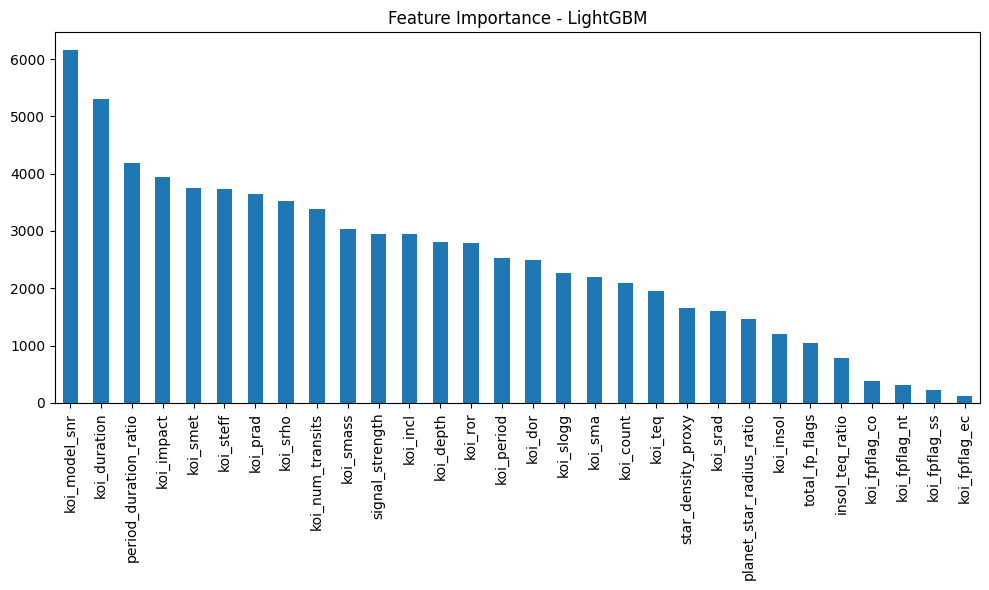

In [38]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========================
# 1️⃣ Split train/val/test
# ========================
X = kepler_clean.drop('target', axis=1)
y = kepler_clean['target']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# ========================
# 2️⃣ Imputer + Scaler
# ========================
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_imputed), columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test.columns)

# ========================
# 3️⃣ Class weights
# ========================
classes, counts = np.unique(y_train, return_counts=True)
print("Train class distribution:", dict(zip(classes, counts)))

class_weights = {0: 1.0, 1: 2.5, 2: 1.7}

# ========================
# 4️⃣ Randomized Search Hyperparameters
# ========================
param_grid = {
    'num_leaves': [31, 63, 127],
    'max_depth': [6, 10, 15, -1],
    'learning_rate': [0.01, 0.03, 0.05],
    'min_child_samples': [20, 40, 60],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

lgb_estimator = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(classes),
    class_weight=class_weights,
    n_estimators=1000,
    random_state=42
)

rs = RandomizedSearchCV(
    lgb_estimator,
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rs.fit(X_train_scaled, y_train)
print("Best params:", rs.best_params_)

# ========================
# 5️⃣ Train final model with early stopping 
# ========================
best_params = rs.best_params_
final_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(classes),
    class_weight=class_weights,
    n_estimators=2000,
    random_state=42,
    **best_params
)

from lightgbm import early_stopping, log_evaluation

final_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric='multi_logloss',
    callbacks=[early_stopping(50), log_evaluation(50)]
)

# ========================
# 6️⃣ Predictions + Report
# ========================
y_val_pred = final_model.predict(X_val_scaled)
print(classification_report(y_val, y_val_pred))

# ========================
# 7️⃣ Feature Importance
# ========================
importance = pd.Series(final_model.feature_importances_, index=X_train.columns)
importance = importance.sort_values(ascending=False)
print(importance)

plt.figure(figsize=(10,6))
importance.plot(kind='bar')
plt.title("Feature Importance - LightGBM")
plt.tight_layout()
plt.show()
